In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import glob

In [190]:
sns.set_theme()

In [191]:
def parse_ev_charging_data(file_path):
    """
    Parses an EVI-Pro (Lite) CSV file containing EV charging data into two separate dataframes for weekdays and weekends.
    """
    def parse_section(lines, start_index, end_index=None):
        """ Helper function to parse a section of the file into a dataframe. """
        data = {}
        current_header = None

        for line in lines[start_index:end_index]:
            line = line.strip()
            if line and not line.startswith('"'):  # This is a header
                current_header = line
                data[current_header] = []
            elif line.startswith('"'):  # This is data
                # Remove quotes and split by comma
                values = line.strip('"').split(',')
                if current_header:
                    data[current_header].extend(values)

        # Convert the dictionary to a dataframe
        return pd.DataFrame.from_dict(data, orient='index', dtype=float).transpose()

    # Read the file as a list of lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Find the start index for weekend data
    weekend_start_index = None
    for i, line in enumerate(lines):
        if "Weekend" in line:
            weekend_start_index = i
            break

    # Parse the weekday and weekend sections
    weekday_data = parse_section(lines, 7, weekend_start_index)  # Weekday data starts from line 7
    weekend_data = parse_section(lines, weekend_start_index + 1)  # Weekend data starts from the found index

    return weekday_data, weekend_data


In [192]:
weekday, weekend = parse_ev_charging_data("../data/load_profile_Boulder_CO.csv")

In [193]:
week = pd.concat([weekday] * 5 + [weekend] * 2)

year = pd.concat([week] * 52)

year

,home_l1,home_l2,work_l1,work_l2,public_l2,public_l3
0,282.10,237.77,0.00,7.2,6.43,0.0
1,277.94,195.57,0.00,7.2,3.60,0.0
2,269.55,160.15,0.00,7.2,3.60,0.0
3,257.42,127.44,0.00,7.2,3.60,0.0
4,247.19,113.19,0.00,7.2,0.00,0.0
...,...,...,...,...,...,...
91,285.19,385.50,0.93,0.0,53.52,0.0
92,280.88,360.24,1.40,0.0,55.20,0.0
93,280.85,354.18,1.40,0.0,57.40,0.0
94,282.84,346.22,1.40,0.0,53.12,0.0


In [194]:
week

,home_l1,home_l2,work_l1,work_l2,public_l2,public_l3
0,282.10,237.77,0.00,7.2,6.43,0.0
1,277.94,195.57,0.00,7.2,3.60,0.0
2,269.55,160.15,0.00,7.2,3.60,0.0
3,257.42,127.44,0.00,7.2,3.60,0.0
4,247.19,113.19,0.00,7.2,0.00,0.0
...,...,...,...,...,...,...
91,285.19,385.50,0.93,0.0,53.52,0.0
92,280.88,360.24,1.40,0.0,55.20,0.0
93,280.85,354.18,1.40,0.0,57.40,0.0
94,282.84,346.22,1.40,0.0,53.12,0.0


In [195]:
time = pd.timedelta_range(start=0, periods=len(week), freq="15min")

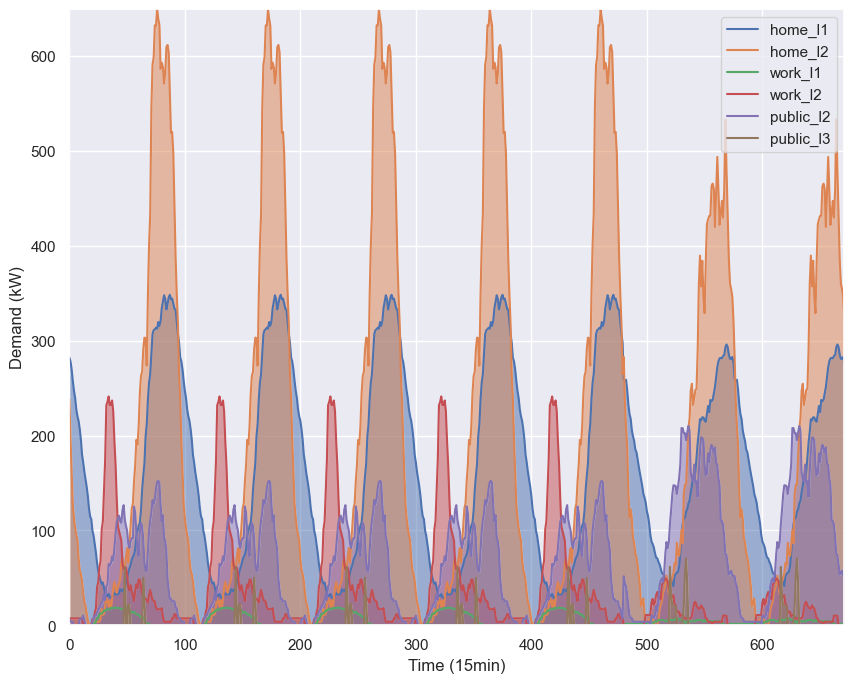

In [196]:
fig, ax = plt.subplots(figsize=(10, 8))

for col in week:
    ax.plot(range(len(week)), week[col].values, label=col)
    ax.fill_between(range(len(week)), 0, week[col].values, alpha=0.5)

ax.set_xlabel("Time (15min)")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.legend()

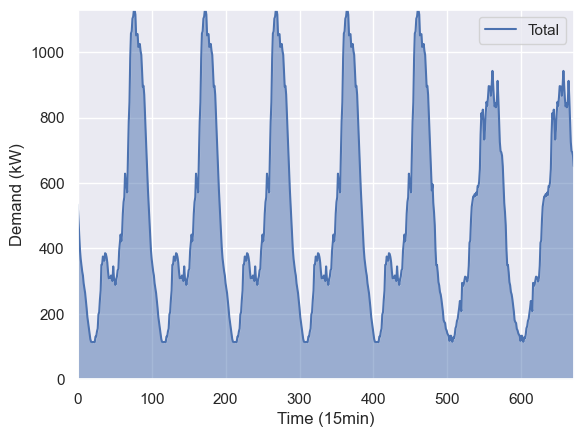

In [197]:
total = week.sum(axis=1)

fig, ax = plt.subplots()

ax.plot(range(len(week)), total, label="Total")
ax.fill_between(range(len(week)), 0, total, alpha=0.5)

ax.set_xlabel("Time (15min)")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.legend()

In [198]:
week = week.set_index(time)

In [199]:
week_hourly = week.resample('H').mean()
num_repeats = 8760 // len(week_hourly)
year_hourly = pd.concat([week_hourly] * num_repeats)

if len(year_hourly) < 8760:
    additional_hours = week_hourly.iloc[:(8760 - len(year_hourly))]
    year_hourly = pd.concat([year_hourly, additional_hours])

year_hourly.index = time = pd.timedelta_range(start=0, periods=8760, freq="H")

year_hourly.tail()

,home_l1,home_l2,work_l1,work_l2,public_l2,public_l3
364 days 19:00:00,317.1375,626.8500,0.0,16.8000,145.0575,0.0
364 days 20:00:00,341.9025,583.5550,0.0,8.6700,101.8200,0.0
364 days 21:00:00,341.4325,596.6075,0.0,3.6000,48.4875,0.0
364 days 22:00:00,340.2100,494.9475,0.0,7.4000,25.8150,0.0
364 days 23:00:00,314.3600,329.6675,0.0,8.3025,13.6350,0.0


In [200]:
year_hourly["total"] = year_hourly.sum(axis=1)

year_hourly

,home_l1,home_l2,work_l1,work_l2,public_l2,public_l3,total
0 days 00:00:00,271.7525,180.2325,0.0,7.2000,4.3075,0.0,463.4925
0 days 01:00:00,233.6675,100.1850,0.0,7.2000,0.0000,0.0,341.0525
0 days 02:00:00,199.2925,57.3950,0.0,7.2000,5.0700,0.0,268.9575
0 days 03:00:00,158.3250,23.0075,0.0,0.4425,3.7625,0.0,185.5375
0 days 04:00:00,121.3825,1.9350,0.0,0.0000,0.0000,0.0,123.3175
...,...,...,...,...,...,...,...
364 days 19:00:00,317.1375,626.8500,0.0,16.8000,145.0575,0.0,1105.8450
364 days 20:00:00,341.9025,583.5550,0.0,8.6700,101.8200,0.0,1035.9475
364 days 21:00:00,341.4325,596.6075,0.0,3.6000,48.4875,0.0,990.1275
364 days 22:00:00,340.2100,494.9475,0.0,7.4000,25.8150,0.0,868.3725


In [201]:
year_hourly["total"].to_csv("../data/boulder_demand_evi.csv", header=False, index=None)